In [43]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import re
import contractions
import wordninja

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Loading

Dataset source: https://www.kaggle.com/datasets/venkatasubramanian/automatic-ticket-classification

In [44]:
df = pd.json_normalize(json.load(open("complaints-2021-05-14_08_16_.json")))

# Basic Data Understanding

- getting basic information such as number of variables, observations, sample data, and value frequencies
- identifying data quality issues

## Dataframe Structure



In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

## Sample Data

In [46]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [47]:
df.tail()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided
78312,complaint-public-v2,complaint,2001189,0.0,None,None,2001189,Payment to acct not credited,2016-07-06T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-07-07T12:00:00-05:00,None,None,Yes,Roughly 10+ years ago I closed out my accounts...,None,Consent provided


In [48]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

## Value Frequencies

In [49]:
df.value_counts('type')

type
complaint    78313
Name: count, dtype: int64

In [50]:
df.value_counts('tags')

tags
Older American                   6103
Servicemember                    3759
Older American, Servicemember    1038
Name: count, dtype: int64

In [51]:
df.value_counts('issue')

issue
Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Adding money                                                                          1
Problem with an overdraft                                                             1
Was approved for a loan, but didn't receive the money                                 1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Overdraft, savings or rewards features                                                1
Name: count, Length: 154, 

In [52]:
df.value_counts('consumer_disputed')

consumer_disputed
N/A    35683
No     33107
Yes     9523
Name: count, dtype: int64

In [53]:
df.value_counts('product')

product
Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                               

In [54]:
df.value_counts('sub_product')

sub_product
Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Government benefit payment card                   4
Gift or merchant card                             4
Medical debt                                      2
ID prepaid card                                   2
Electronic Benefit Transfer / EBT card            1
Name: count, Length: 72, dtype: int64

In [55]:
df.value_counts('timely')

timely
Yes    78217
No        96
Name: count, dtype: int64

In [56]:
df.value_counts('complaint_what_happened')

complaint_what_happened
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [57]:
df.value_counts('sub_issue')

sub_issue
Credit card company isn't resolving a dispute about a purchase on your statement    2904
Deposits and withdrawals                                                            2759
Company closed your account                                                         2020
Problem using a debit or ATM card                                                   1613
Card was charged for something you did not purchase with the card                   1056
                                                                                    ... 
Problem cancelling or closing account                                                  1
Incorrect information on your report                                                   1
Problem with direct deposit                                                            1
Report shared with employer w/o consent                                                1
Receiving unwanted marketing/advertising                                               1
Name: count

In [58]:
df.value_counts('consumer_consent_provided')

consumer_consent_provided
N/A                     42847
Consent provided        21077
Consent not provided    12285
Other                     991
Consent withdrawn         105
Name: count, dtype: int64

## Word Count

In [59]:
def word_count(text):
    if text=="":
        return 0
    else:
        return len(str(text).split(' '))

In [60]:
word_count_df = pd.DataFrame({
    'word_count':df['complaint_what_happened'].apply(word_count)
})
word_count_df['word_count'].describe()

count    78313.000000
mean        68.342893
std        180.518156
min          0.000000
25%          0.000000
50%          0.000000
75%         42.000000
max       5556.000000
Name: word_count, dtype: float64

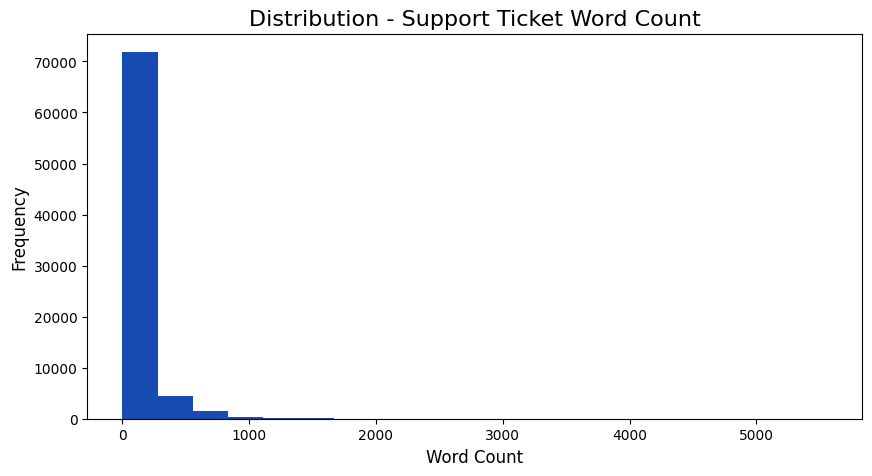

In [61]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    word_count_df['word_count'],
    bins=20,
    color='#184cb2'
)

plt.title('Distribution - Support Ticket Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)

plt.show()

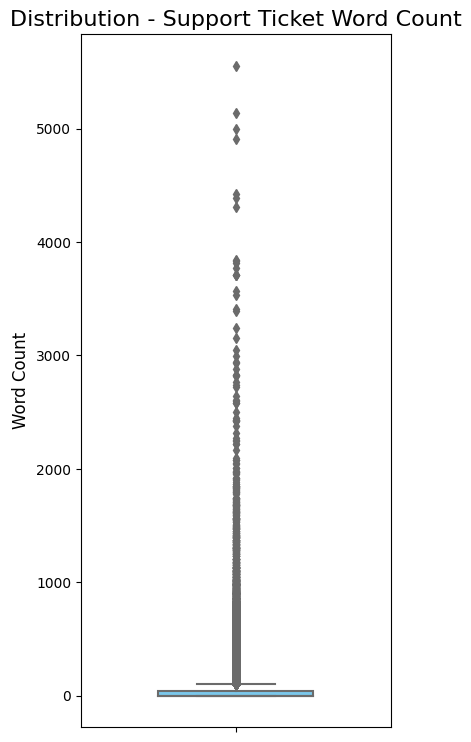

In [62]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    y = word_count_df['word_count'],
    orient='v',
    width=.5,
    color='#67cefe'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Support Ticket Word Count', fontsize=16)

plt.show()

## Data Quality Issues

### Null Values

In [63]:
# null or empty values
null_count_df = pd.DataFrame({'columns':df.columns,
                              'empty_string_count':list(map(lambda column: (df[column] == '').sum(), df.columns)),
                              'null_value_count':list(map(lambda column: (df[column] == np.nan).sum(), df.columns))})
null_count_df

,columns,empty_string_count,null_value_count
0,index,0,0
1,type,0,0
2,id,0,0
3,score,0,0
4,tags,0,0
5,zip_code,0,0
6,complaint_id,0,0
7,issue,0,0
8,date_received,0,0
9,state,0,0


### Masked Values

In [64]:
# masked values
masked_text_pattern = r"\b[x|X]{2,20}"
masked_df = pd.DataFrame({
    'number_of_masked':df['complaint_what_happened'].apply(lambda text:len(re.findall(masked_text_pattern, text))), 
    'masked':df['complaint_what_happened'].apply(lambda text:re.findall(masked_text_pattern, text))})
df_with_masked = masked_df[masked_df['number_of_masked']!=0]
df_with_masked

,number_of_masked,masked
1,6,"[XXXX, XXXX, XXXX, XXXX, XXXX, XXXX]"
2,12,"[XXXX, XXXX, XX, XX, XXXX, XX, XX, XXXX, XX, X..."
10,2,"[XX, XX]"
11,10,"[XX, XX, XXXX, XXXX, XXXX, XXXX, XX, XX, XX, XX]"
14,4,"[XX, XX, XXXX, XXXX]"
...,...,...
78303,1,[XXXX]
78309,11,"[XX, XX, XXXX, XXXX, XXXX, XX, XX, XXXX, XXXX,..."
78310,8,"[XXXX, XXXX, XXXX, XXXX, XXXX, XXXX, XXXX, XXXX]"
78311,13,"[XXXX, XX, XX, XXXX, XX, XX, XXXX, XX, XX, XXX..."


In [65]:
df_with_masked.value_counts('number_of_masked')

number_of_masked
2       1519
3       1215
1       1201
4       1060
6       1008
        ... 
195        1
196        1
198        1
201        1
1119       1
Name: count, Length: 211, dtype: int64

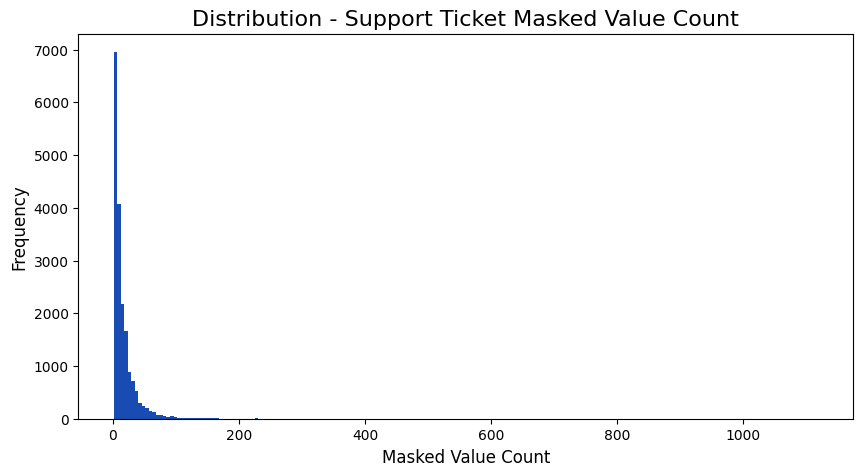

In [66]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df_with_masked['number_of_masked'],
    bins=200,
    color='#184cb2'
)

plt.title('Distribution - Support Ticket Masked Value Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Masked Value Count', fontsize=12)

plt.show()

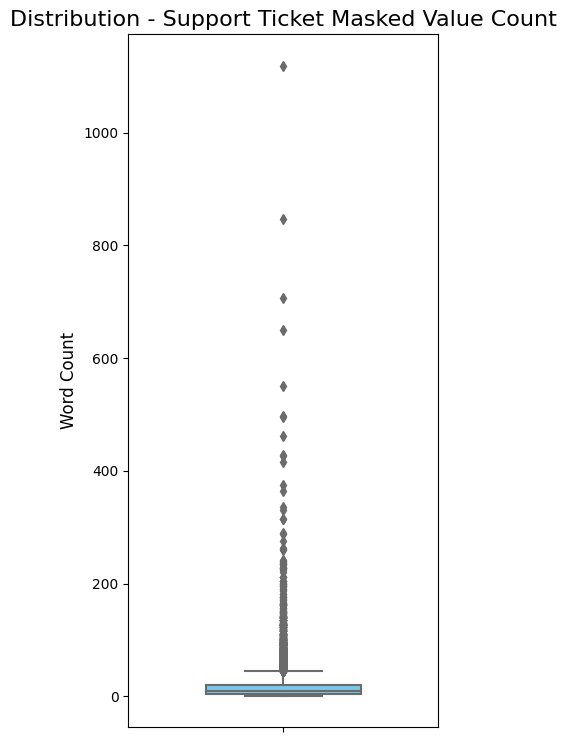

In [67]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    y = df_with_masked['number_of_masked'],
    orient='v',
    width=.5,
    color='#67cefe'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Support Ticket Masked Value Count', fontsize=16)

plt.show()

### Concatenated words

In [68]:
list_a = list(word_count_df[word_count_df['word_count']==1].index)
list_a

for i in df.iloc[list_a,-3]:
    print(f'{i}\n{"="*50}')

ChaseMortgagehasautomaticallydeducted2mortgagepaymentsfrommyXXXXXXXXcheckingaccountwithoutmypermission.Iamnotsetupuponautomaticpayments.IdidnotauthorizethemtodeductandIamcurrentonmyloan.
IreceivedanemailXX/XX/XXXXthatmycreditcardswereclosedimmediately.ThatisinviolationwithCIVILCODE-CIVDIVISION3.OBLIGATIONS[1427-3273](HeadingofDivision3amendedbyStats.1988,Ch.160,Sec.14.)PART4.OBLIGATIONSARISINGFROMPARTICULARTRANSACTIONS[1738-3273](Part4enacted1872.)TITLE1.3.CREDITCARDS[1747-1748.95](Title1.3addedbyStats.1971,Ch.1019.)1747.85.
Unlessrequestedbythecardholder,nocardissuershallcancelacreditcardwithouthavingfirstgiventhecardholder30dayswrittennoticeofitsintentiontodosounlessthecardholderisorhasbeenwithinthelast90daysindefaultofpaymentorotherwiseinviolationofanyprovisionoftheagreementbetweenthecardissuerandthecardholdergoverningthecardholdersuseofthecreditcardorunlessthecardissuerhasevidenceorreasonablebeliefthatthecardholderisunableorunwillingtorepayobligationsincurredundertheagreementorthat

In [69]:
# Probabilistically split concatenated words using NLP based on English Wikipedia unigram frequencies.
# https://github.com/keredson/wordninja
for i in df.iloc[list_a,-3].apply(lambda concat_text:" ".join(wordninja.split(concat_text))):
    print(f'{i}\n{"="*50}')

Chase Mortgage has automatically deducted 2 mortgage payments from my XXXX XXXX checking account without my permission Iam not setup upon automatic payments I did not authorize them to deduct and Iam current on my loan
I received an email XX XX XXXX that my credit cards were closed immediately That is in violation with CIVIL CODE CIV DIVISION 3 OBLIGATIONS 1427 3273 Heading of Division 3 amended by Stats 1988 Ch 160 Sec 14 PART 4 OBLIGATIONS ARISING FROM PARTICULAR TRANSACTIONS 1738 3273 Part 4 enacted 1872 TITLE 1 3 CREDIT CARDS 1747 1748 95 Title 1 3 added by Stats 1971 Ch 1019 1747 85 Unless requested by the card holder no card issuers hall cancel a credit card without having first given the card holder 30 days written notice of its intention to do so unless the card holder is or has been within the last 90 days in default of payment or otherwise in violation of any provision of the agreement between the card issuer and the card holder governing the card holders use of the credit ca

In [70]:
split_text_df = pd.DataFrame(columns=['before','after','after_after'])

list_j = list(word_count_df[word_count_df['word_count']!=0].index)
before = df.iloc[list_j,-3]
after = df.iloc[list_j,-3].apply(lambda concat_text:" ".join(wordninja.split(concat_text)))

split_text_df.before = before
split_text_df.after = split_text_df.before.apply(lambda concat_text:" ".join(wordninja.split(concat_text)))
split_text_df.after_after = split_text_df.after.apply(lambda concat_text:" ".join(wordninja.split(concat_text)))

split_text_df

,before,after,after_after
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX XX 2018 and...,I upgraded my XXXX XXXX card in XX XX 2018 and...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card was reported on XX XX 2019 However ...,Chase Card was reported on XX XX 2019 However ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",On XX XX 2018 while trying to book a XXXX XXXX...,On XX XX 2018 while trying to book a XXXX XXXX...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for 1600 00 i depos...,my grand son give me check for 1600 00 i depos...
...,...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",On Wednesday XX XX XXXX I called Chas my XXXX ...,On Wednesday XX XX XXXX I called Chas my XXXX ...
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yrs I've had...,I have had flawless credit for 30 yrs I've had...


In [71]:
(split_text_df.before==split_text_df.after).value_counts()

False    20881
True       191
Name: count, dtype: int64

In [72]:
(split_text_df.after==split_text_df.after_after).value_counts()

True    21072
Name: count, dtype: int64

# NLP Data Preprocessing

In [73]:
def clean_text(text):
  # Case-folding (Lowercase)
  text = text.lower()
  
  # Split Concatenated Words
  text = " ".join(wordninja.split(text))

  # Remove url
  url_pattern = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
  text = url_pattern.sub(r'', text)

  # Remove emoji
  emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"  # other miscellaneous symbols
                                u"\U000024C2-\U0001F251"  # enclosed characters
                              "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Expand Contractions
  text = contractions.fix(text)
  
  # Remove Punctuation, and words containing numbers
  punt_pattern = '[^\w\s]'
  word_with_num_pattern = '\w*\d\w*'
  text = re.sub(punt_pattern, '', text)
  text = re.sub(word_with_num_pattern, '', text)

  # Tokenisation
  tokens = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  return tokens

def lemmatise_with_pos_tagged(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmas = []
  for word, tag in pos_tag(tokens):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    lemmas.append(lemmatizer.lemmatize(word, wntag) if wntag else word)
  return lemmas

def further_clean(tokens):
  # remove repeating characters from tokens
  RepeatTokensRm =  " ".join( [ re.sub(r'(\w)\1{2,}', r'\1', word) for word in tokens] )
  # Remove tokens containing digits
  digitTokensRm =  " ".join( [ word for word in RepeatTokensRm.split() if not re.search(r'\d', word) ] ) 
  # Remove tokens containing underscore
  underscoreTokensRm =  " ".join( [ word for word in digitTokensRm.split() if not re.search(r'_|\w*_\w*', word) ] )
  # Remove tokens containing Special Characters
  specialTokensRm =  " ".join( [ word for word in underscoreTokensRm.split() if not re.search(r'[^a-zA-Z0-9\s]', word) ] )
  # Remove tokens less than 2 characters
  return " ".join( [ word for word in specialTokensRm.split() if len(word) > 2 ] )

In [74]:
def preprocess_text(text):
    tokens = clean_text(text)
    lemmas = lemmatise_with_pos_tagged(tokens)
    preprocessed_text = further_clean(lemmas)
    return preprocessed_text

In [75]:
# drop unnecessary columns
df.drop(['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'sub_issue','consumer_consent_provided'],axis=1,inplace=True)

# remove values containing empty strings or only whitespaces of complaint_what_happened column
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.dropna(inplace=True)

# Apply text preprocessing to the 'complaint_what_happened' column
df['preprocessed_text'] = df['complaint_what_happened'].apply(preprocess_text)

# Display the preprocessed text
df.head()

,complaint_what_happened,preprocessed_text
1,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary d...
10,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply toward...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...


# Exploratory Data Analysis

## Word Count

In [76]:
preprocessed_word_count_df = pd.DataFrame({
    'word_count':df['preprocessed_text'].apply(word_count)
})
preprocessed_word_count_df['word_count'].describe()

count    21072.000000
mean       109.106112
std        117.292177
min          1.000000
25%         42.000000
50%         78.000000
75%        137.000000
max       2758.000000
Name: word_count, dtype: float64

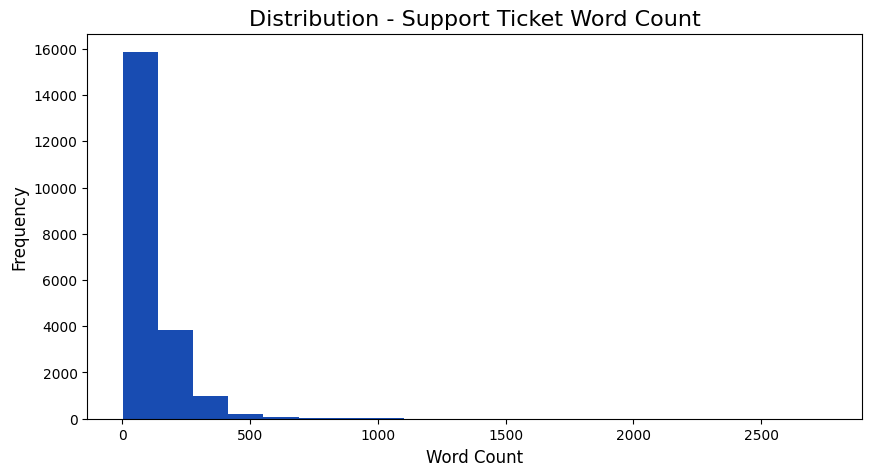

In [77]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    preprocessed_word_count_df['word_count'],
    bins=20,
    color='#184cb2'
)

plt.title('Distribution - Support Ticket Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)

plt.show()

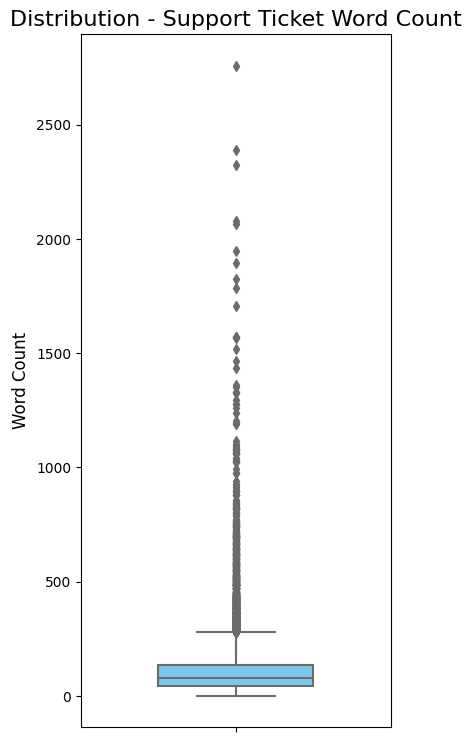

In [78]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    y = preprocessed_word_count_df['word_count'],
    orient='v',
    width=.5,
    color='#67cefe'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Support Ticket Word Count', fontsize=16)

plt.show()

## Unigram

In [79]:
from nltk.tokenize import word_tokenize

text = " ".join(list(df['preprocessed_text']))
uni_tokens = word_tokenize(text)
unigram_df = pd.DataFrame({'unigram':uni_tokens})

unigram_freq_df = unigram_df.groupby('unigram').size().reset_index(name='count').sort_values(by='count', ascending=False)
unigram_freq_df.iloc[:49]

,unigram,count
2173,chase,81664
110,account,48980
3199,credit,34353
1952,card,31358
1199,bank,28868
1875,call,26175
10236,payment,21541
16200,would,21037
2162,charge,18641
14341,tell,17574


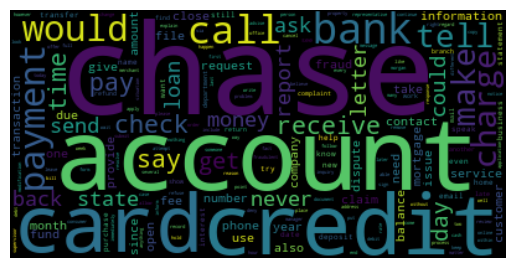

In [80]:
d = {}
for a, x in unigram_freq_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Bigram Frequency

In [81]:
import itertools
from nltk import bigrams
from nltk.tokenize import word_tokenize


text = list(df['preprocessed_text'])
bigrams_2dlist = [list(bigrams(word_tokenize(txt))) for txt in text]
bigrams_flattenlist = list(itertools.chain.from_iterable(bigrams_2dlist))

bigram_df = pd.DataFrame({'bigram':bigrams_flattenlist})

bigram_freq_df = bigram_df.groupby('bigram').size().reset_index(name='count').sort_values(by='count', ascending=False)
bigram_freq_df.iloc[:49]

,bigram,count
102588,"(chase, bank)",12968
147857,"(credit, card)",12901
86506,"(call, chase)",5036
148742,"(credit, report)",4011
106100,"(check, account)",3845
153047,"(customer, service)",3092
114102,"(close, account)",2671
103005,"(chase, credit)",2629
367698,"(morgan, chase)",2592
4989,"(account, chase)",2478


## Trigram Frequency

In [82]:
import itertools
from nltk import trigrams
from nltk.tokenize import word_tokenize


text = list(df['preprocessed_text'])
trigrams_2dlist = [list(trigrams(word_tokenize(txt))) for txt in text]
trigrams_flattenlist = list(itertools.chain.from_iterable(trigrams_2dlist))

trigram_df = pd.DataFrame({'trigram':trigrams_flattenlist})
trigram_freq_df = trigram_df.groupby('trigram').size().reset_index(name='count').sort_values(by='count', ascending=False)
trigram_freq_df.iloc[:49]

,trigram,count
317061,"(chase, credit, card)",2276
452645,"(credit, card, account)",979
452868,"(credit, card, company)",960
452842,"(credit, card, chase)",749
992214,"(morgan, chase, bank)",705
14780,"(account, chase, bank)",659
241243,"(call, chase, bank)",601
317413,"(chase, customer, service)",583
242653,"(call, customer, service)",531
1251038,"(receive, letter, chase)",482


# Export df to CSV

In [83]:
df['preprocessed_text'].to_csv("process_csv_stage_1.csv")

In [84]:
df[df['preprocessed_text']==""]["complaint_what_happened"]

Series([], Name: complaint_what_happened, dtype: object)